# Fourier slice integration

In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import jax.numpy as jnp
from matplotlib import pyplot as plt

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities = read_atoms_from_pdb("./data/5w0s.pdb")
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities)

In [88]:
# Evaluate the potential on a voxel grid
shape = (300, 300, 300)
voxel_size = 1.0
real_voxel_grid = atom_potential.as_real_voxel_grid(
    shape,
    voxel_size,
    z_planes_in_parallel=10,
)

# Multislice integrator

In [89]:
potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid,
    voxel_size,
)

In [90]:
instrument_config = cxs.InstrumentConfig(
    shape=potential.shape[0:2],
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
)

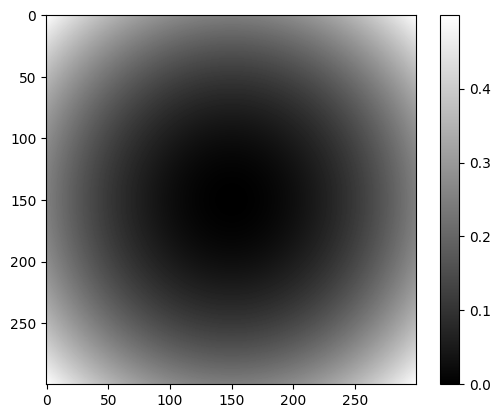

In [91]:
kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
k2 = jnp.hypot(kx, ky) ** 2
plt.imshow(jnp.fft.fftshift(k2), cmap="gray")
plt.colorbar()

In [92]:
from cryojax.experimental import FFTMultisliceIntegrator

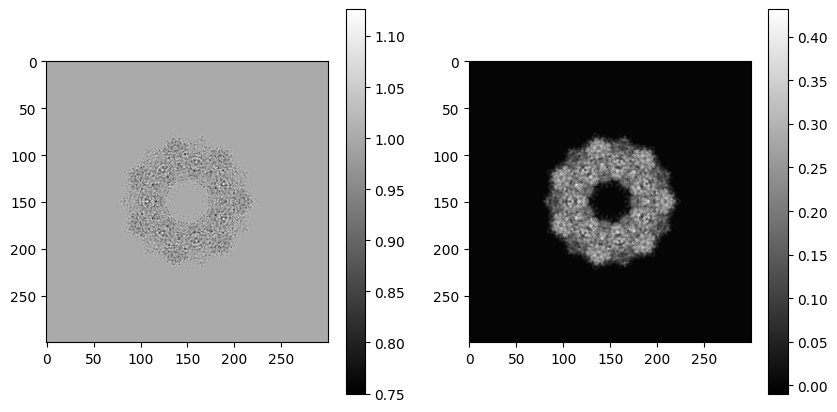

In [93]:
multislice_integrator = FFTMultisliceIntegrator()

exit_wave = multislice_integrator.compute_wavefunction_at_exit_plane(
    potential, instrument_config
)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im0 = axes[0].imshow(exit_wave.real, cmap="gray")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(exit_wave.imag, cmap="gray")
fig.colorbar(im1, ax=axes[1])

In [122]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose()
structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

wtf = cxe.WaveTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
ctf = cxs.ContrastTransferFunction(
    defocus_in_angstroms=wtf.defocus_in_angstroms,
    astigmatism_in_angstroms=wtf.astigmatism_in_angstroms,
    astigmatism_angle=wtf.astigmatism_angle,
    amplitude_contrast_ratio=wtf.amplitude_contrast_ratio,
)

In [123]:
multislice_scattering_theory = cxe.MultisliceScatteringTheory(
    structural_ensemble, multislice_integrator, cxe.WaveTransferTheory(wtf)
)
high_energy_scattering_theory = cxe.HighEnergyScatteringTheory(
    structural_ensemble, cxs.NufftProjection(), cxe.WaveTransferTheory(wtf)
)
weak_phase_scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, cxs.NufftProjection(), cxs.ContrastTransferTheory(ctf)
)

In [124]:
multislice_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, multislice_scattering_theory
)
high_energy_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, high_energy_scattering_theory
)
weak_phase_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, weak_phase_scattering_theory
)

im1, im2, im3 = (
    multislice_imaging_pipeline.render(),
    high_energy_imaging_pipeline.render(),
    weak_phase_imaging_pipeline.render(),
)

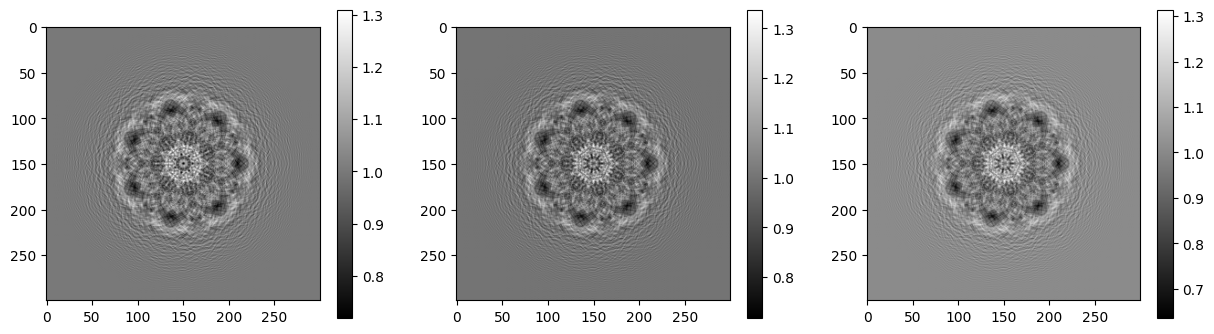

In [125]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
m1 = axes[0].imshow(im1, cmap="gray")
m2 = axes[1].imshow(im2, cmap="gray")
m3 = axes[2].imshow(im3, cmap="gray")
fig.colorbar(m1)
fig.colorbar(m2)
fig.colorbar(m3)